<h1>Adversarial autoencoder</h1>

문제가 생기는부분은 semi-supervised autoencoder부분이라 앞부분은 그냥 넘어가셔도 됩니다.  

11/12 : 1차디버그 완료. 정상적인 훈련이 되긴 했는데 논문에 비해 훨씬 불안정합니다. 아직도 lr을 1/10으로 줄여야 학습ㅁ이 되고 이 이상으로 올리면 collapse하거나 발산해버립니다.

바로가기 :  

[semi-supervsied autoencoder](#ssaae)

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_swiss_roll

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_train = tf.convert_to_tensor(x_train, dtype='float32')
x_test = tf.convert_to_tensor(x_test, dtype = 'float32')
y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_test_ohe = tf.keras.utils.to_categorical(y_test)
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_ohe))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

<h3>adversarial autoencoder</h3>

In [63]:
class AAE(tf.keras.Model):
    def __init__(self, n_layers, n_nodes, n_components, input_dim, prior_distribution = 'gaussian'):
        super(AAE, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        if prior_distribution not in ['gaussian', 'roll']:
            raise ValueError('prior must be gaussian or roll')
        else:
            self.prior_distribution = prior_distribution
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.input_dim])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.n_components])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components]),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])

    @tf.function
    def encode(self, x):
        latent_z = self.encoder(x)
        return latent_z

    @tf.function
    def discriminate_z(self, z):
        output = self.discriminator_z(z)
        return output

    @tf.function
    def decode(self,z):
        reconstruction = self.decoder(z)
        return reconstruction
    
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

@tf.function
def train_step(model, x, r_optimizer, d_optimizer, g_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        reconstruction = model.decode(latent_z)
        reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial_z
    model.discriminator_z.trainable = True
    model.encoder.trainable = False
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        true_output_z = tf.convert_to_tensor(make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)[0][:,[0,2]], dtype = 'float32')
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator_z
    model.discriminator_z.trainable = False
    model.encoder.trainable = True 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_output = model.discriminate_z(latent_z)
        generator_z_loss = compute_generator_loss(fake_z_output)
    g_gradients = tape.gradient(generator_z_loss, model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    return reconstruction_loss, discriminator_z_loss, generator_z_loss          

@tf.function
def test_step(model, x):
    latent_z = model.encode(x)
    reconstruction = model.decode(latent_z)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        true_output_z = tf.convert_to_tensor(make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)[0][:,[0,2]], dtype = 'float32')
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    return reconstruction_loss, discriminator_z_loss, generator_z_loss

In [46]:
aae = AAE(2, 1000, 2, len(x_train[0]), prior_distribution = 'roll')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_history = []
for i in tqdm(range(5000)):
    if i == 49:
        r_optimizer.lr = .0001
        d_optimizer.lr = .001
        g_optimizer.lr = .001
    elif i == 999:
        r_optimizer.lr = .00001
        d_optimizer.lr = .0001
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(aae, x_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(aae, x_test)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

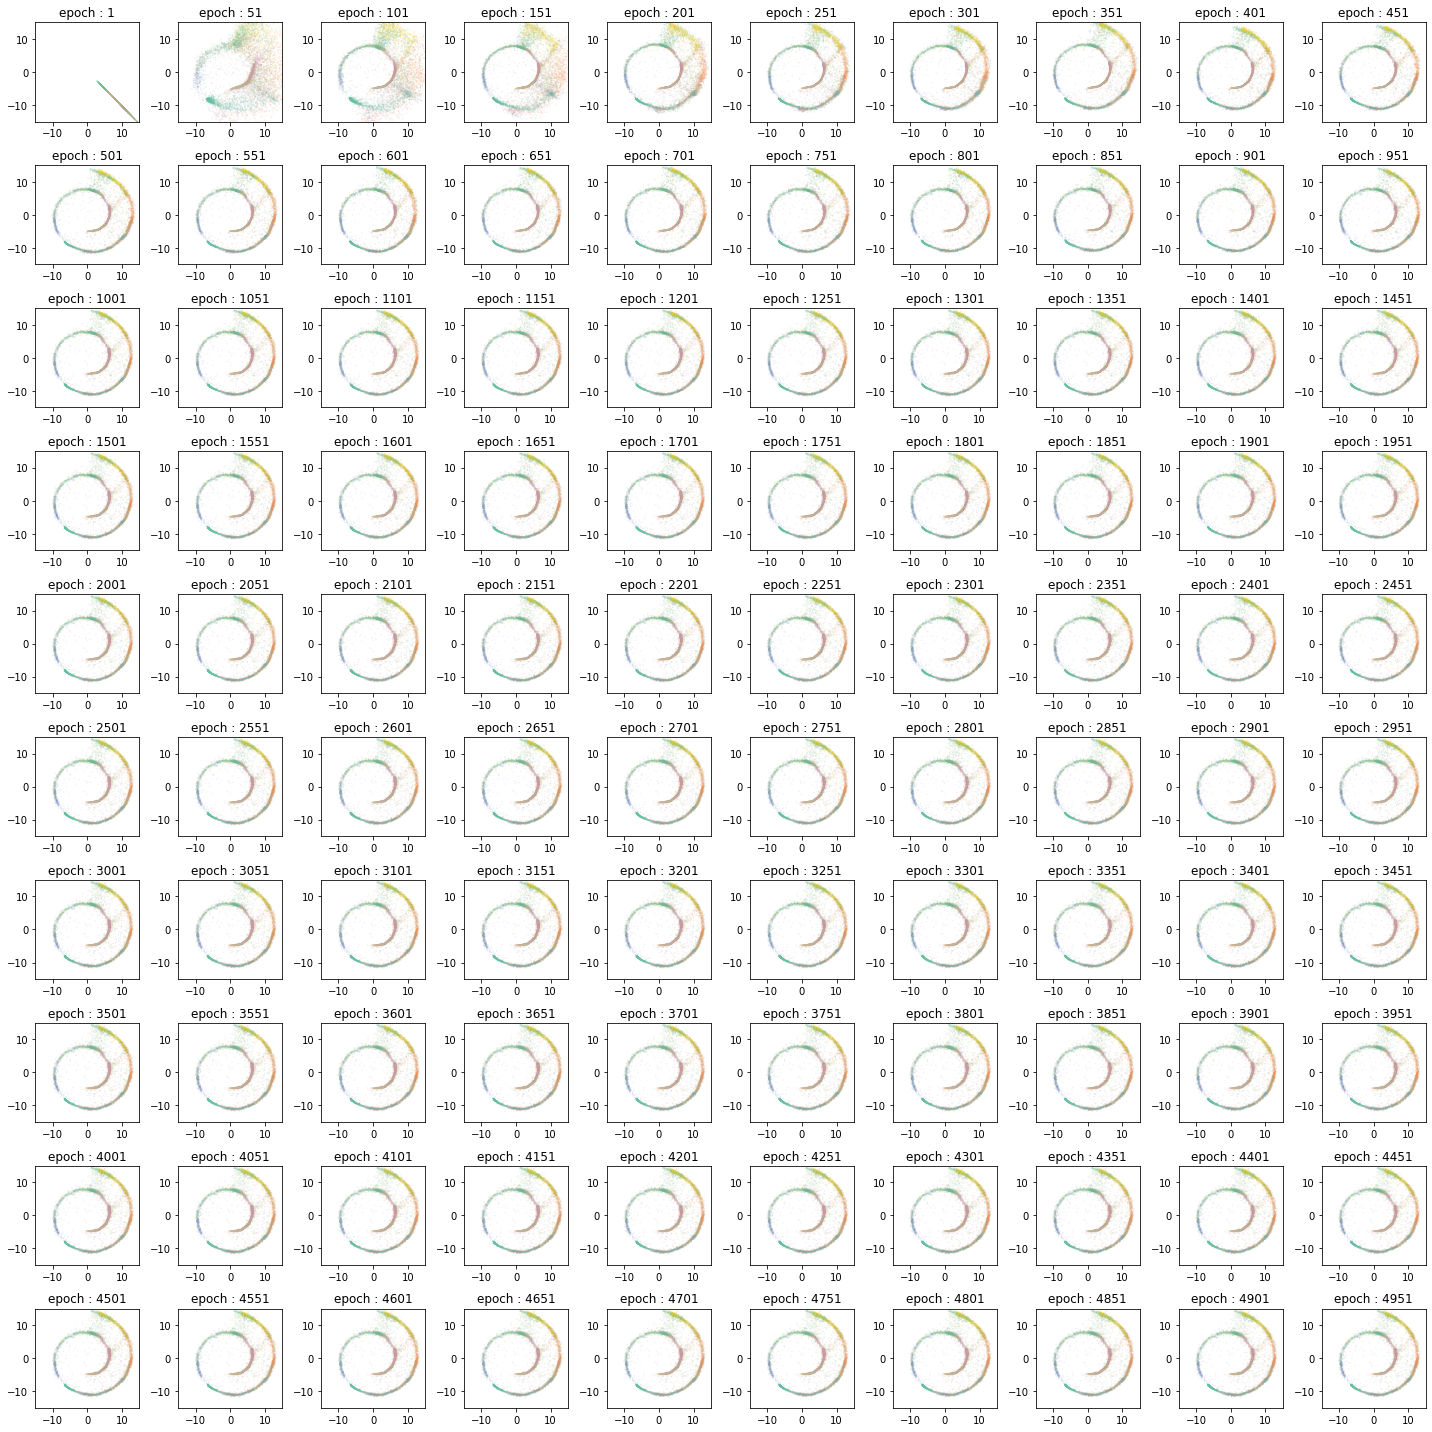

In [51]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i * 50][:,0], latent_history[i * 50][:,1], c = y_test, cmap = plt.cm.Set2, alpha = .7, s = .01)
    ax[i//10, i%10].set_title(f'epoch : {(i * 50) + 1}')
    ax[i//10, i%10].set_xlim(-15,15)
    ax[i//10, i%10].set_ylim(-15,15)
plt.tight_layout()

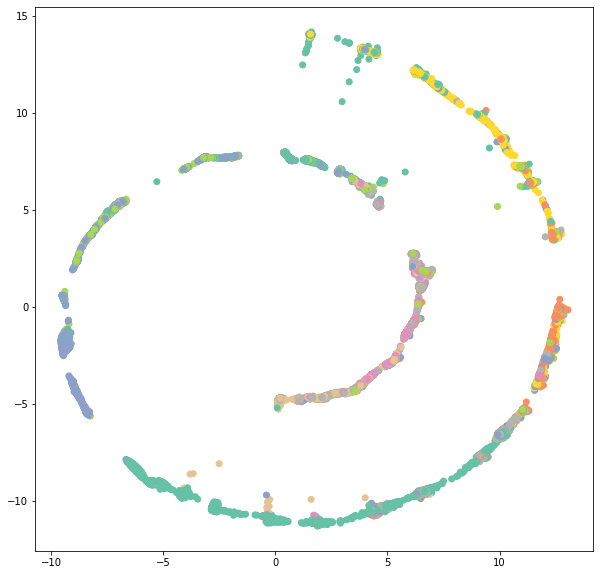

In [58]:
fig, ax = plt.subplots(figsize = (10, 10))
latent_z = aae.encode(x_train)
ax.scatter(latent_z[:,0], latent_z[:,1], c = y_train, cmap = plt.cm.Set2)

In [64]:
aae = AAE(2, 1000, 2, len(x_train[0]), prior_distribution = 'gaussian')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_history = []
for i in tqdm(range(1000)):
    if i == 49:
        r_optimizer.lr = .0001
        d_optimizer.lr = .001
        g_optimizer.lr = .001
    elif i == 999:
        r_optimizer.lr = .00001
        d_optimizer.lr = .0001
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(aae, x_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(aae, x_test)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

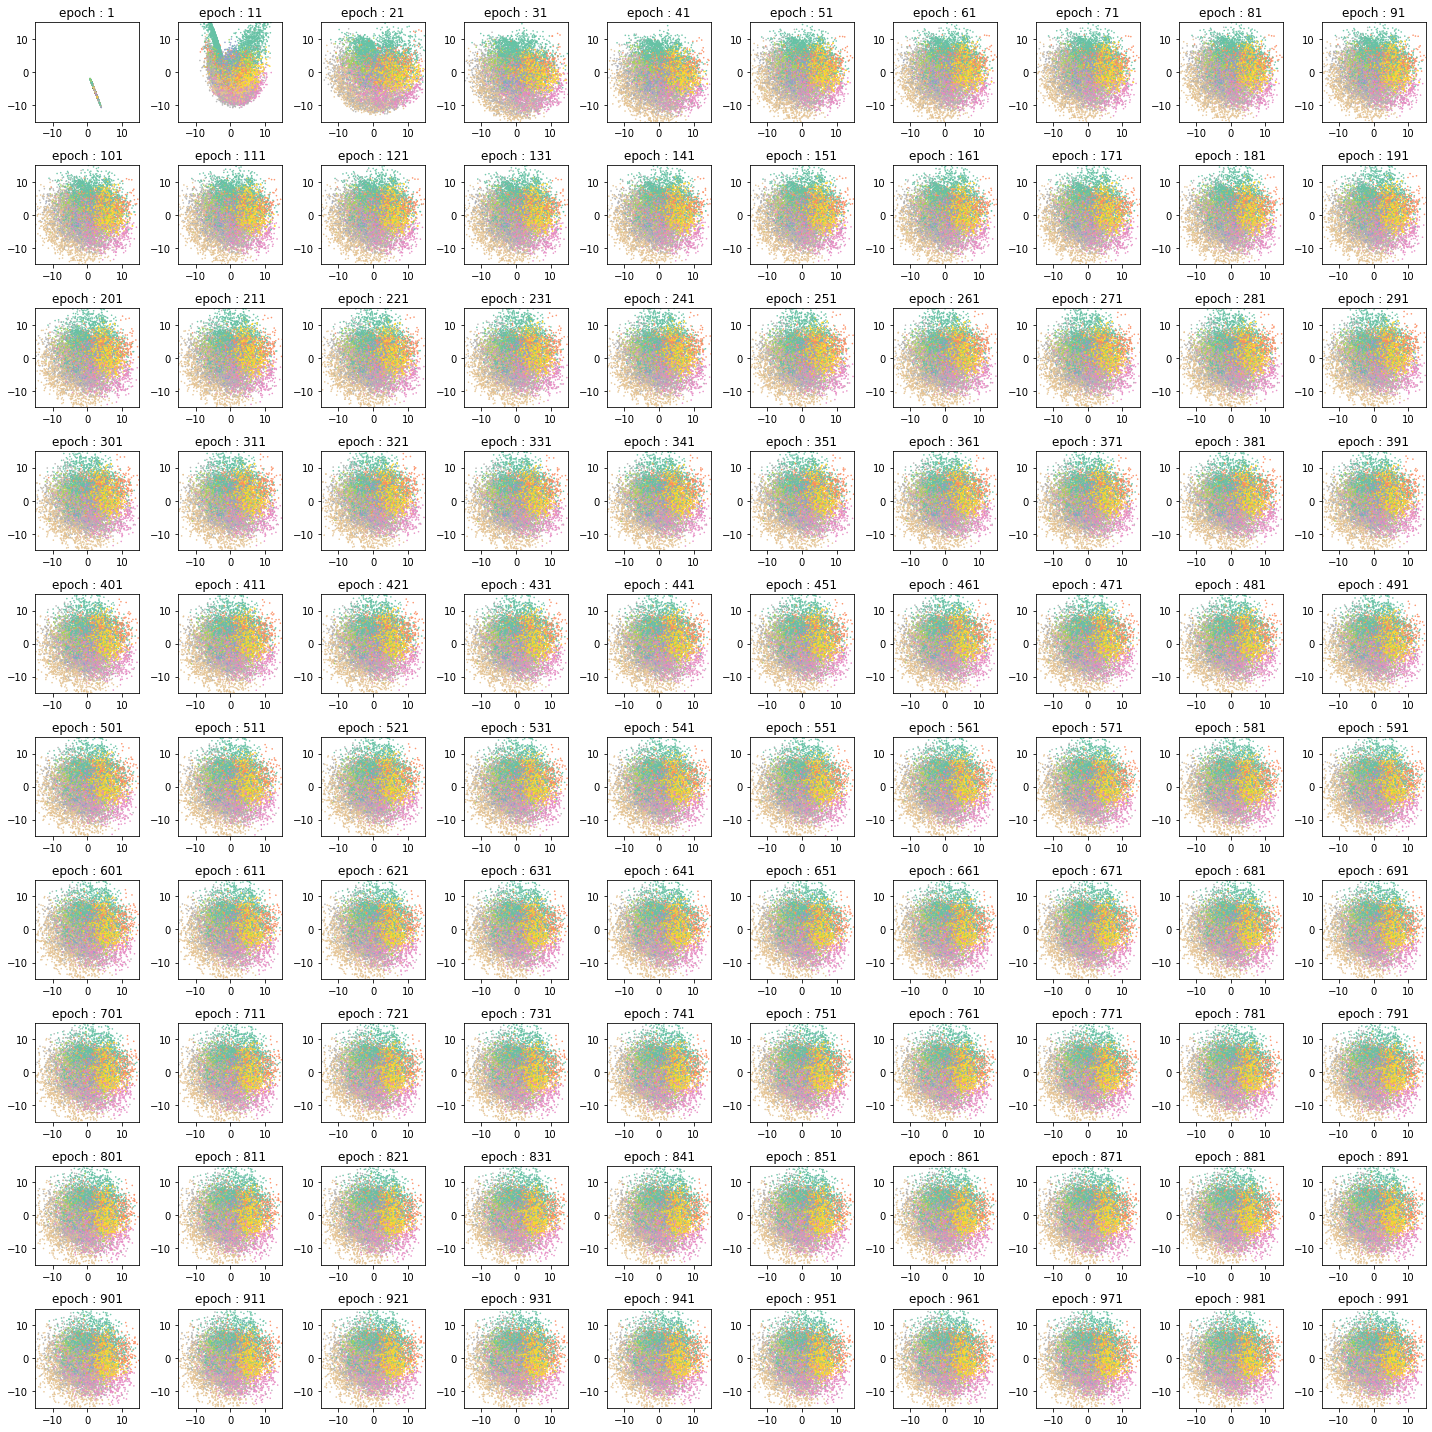

In [75]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i * 10][:,0], latent_history[i * 10][:,1], c = y_test, cmap = plt.cm.Set2, s = .3)
    ax[i//10, i%10].set_title(f'epoch : {(i * 10) + 1}')
    ax[i//10, i%10].set_xlim(-15,15)
    ax[i//10, i%10].set_ylim(-15,15)
plt.tight_layout()

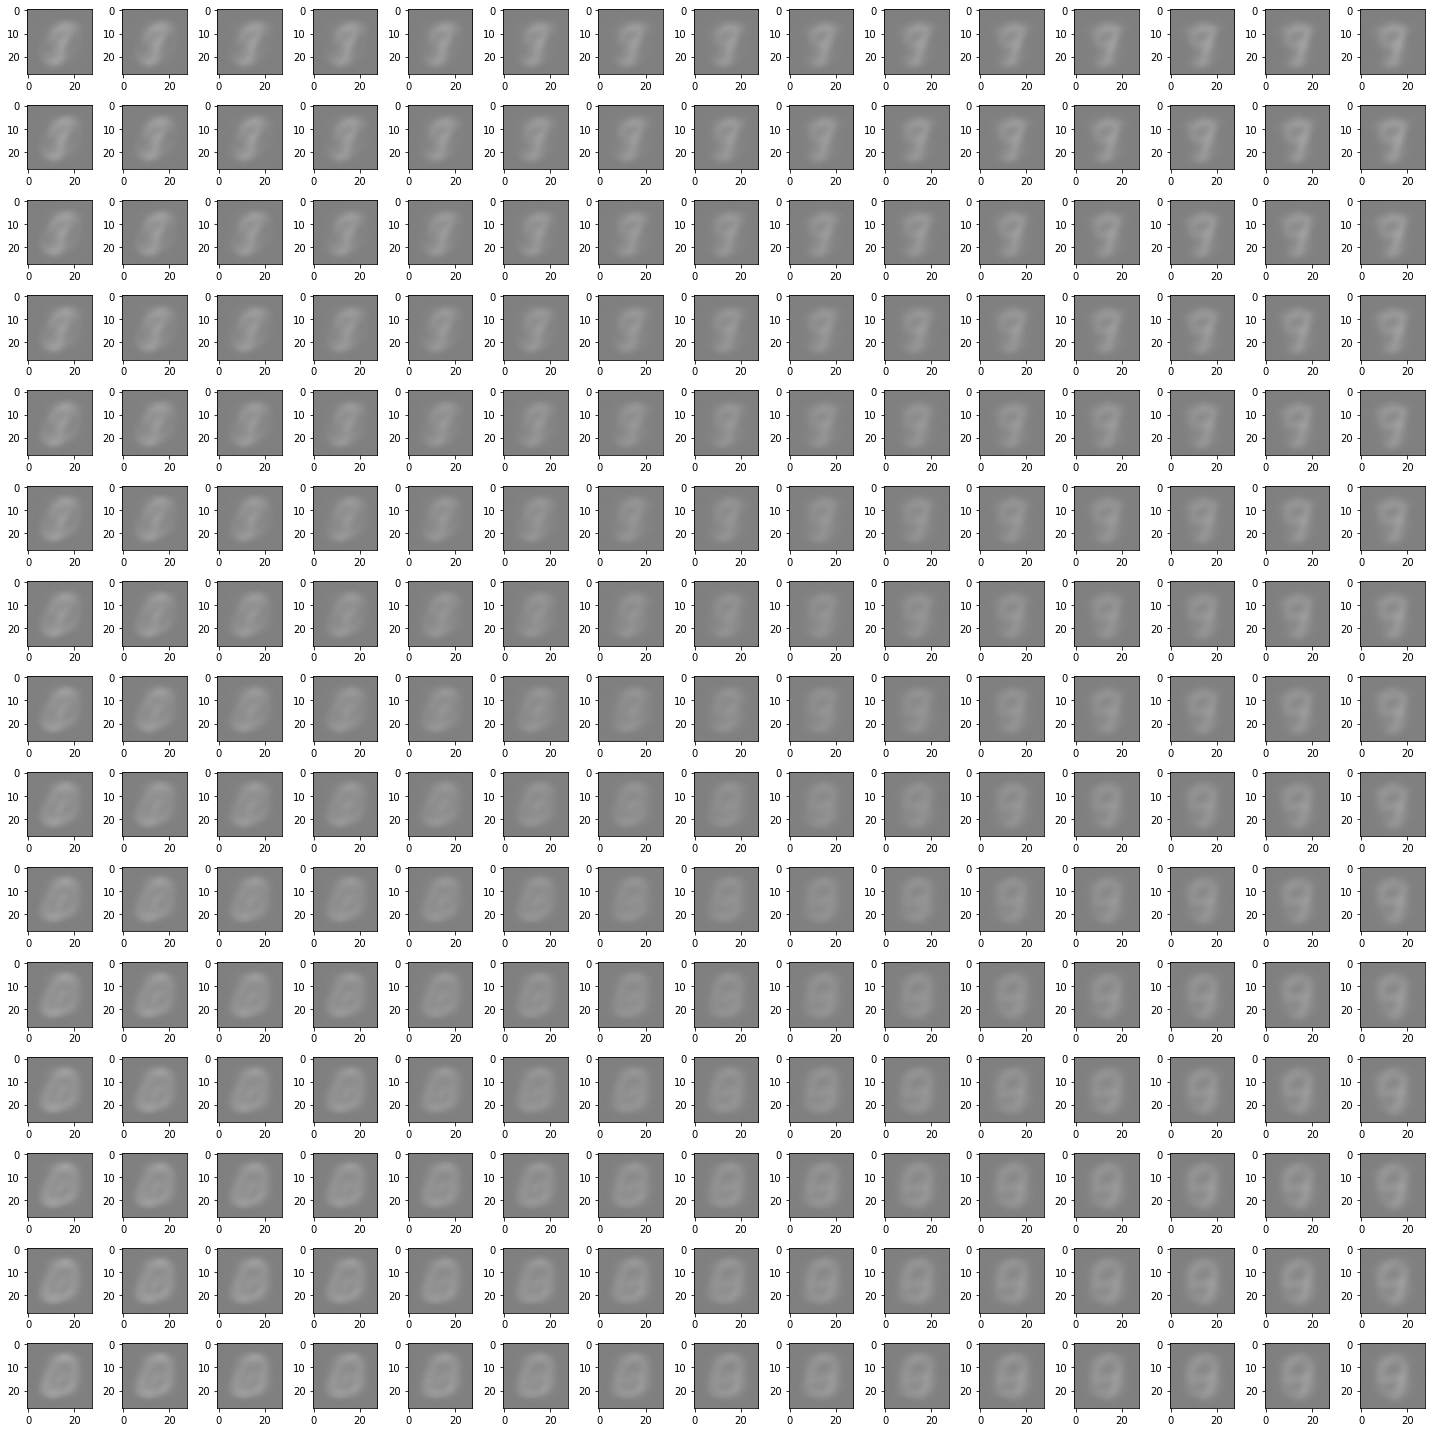

In [91]:
latent = tf.convert_to_tensor([[x,y] for x in np.linspace(-3, 3, 15) for y in np.linspace(3, -3, 15)], dtype = 'float32')
res = tf.math.sigmoid(aae.decode(latent))
res = tf.reshape(res, shape = (15*15, 28, 28)).numpy()

fig, ax = plt.subplots(15, 15, figsize = (20,20))
for i in range(15*15):
    ax[i//15, i%15].imshow(res[i], cmap = 'gist_gray', vmin=0, vmax=1.)
plt.tight_layout()

<h3>label incorporated adversarial autoencoder</h3>

In [91]:
class lr_AAE(tf.keras.Model):
    def __init__(self, n_layers, n_nodes, n_components, input_dim, n_categories, prior_distribution = 'gaussian'):
        super(lr_AAE, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.n_categories = n_categories
        self.input_dim = input_dim
        if prior_distribution not in ['gaussian', 'roll']:
            raise ValueError('prior must be gaussian or roll')
        else:
            self.prior_distribution = prior_distribution
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.input_dim])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.n_components])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components + self.n_categories]),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])

    @tf.function
    def encode(self, x):
        latent_z = self.encoder(x)
        return latent_z

    @tf.function
    def discriminate_z(self, z, y):
        inputs = tf.concat([z,y], axis = 1)
        output = self.discriminator_z(inputs)
        return output

    @tf.function
    def decode(self,z):
        reconstruction = self.decoder(z)
        return reconstruction
    
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

@tf.function
def train_step(model, x, y, r_optimizer, d_optimizer, g_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        reconstruction = model.decode(latent_z)
        reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial_z
    model.discriminator_z.trainable = True
    model.encoder.trainable = False
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        temp_z, temp_y = make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)
        true_output_z = tf.convert_to_tensor(temp_z[:,[0,2]], dtype = 'float32')
        y_true = tf.keras.utils.to_categorical(np.digitize(temp_y, np.linspace(4.712441162324161, 14.137091941626444, 10)) - 1,num_classes=10) 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_logit = model.discriminate_z(latent_z, y)
        true_z_logit = model.discriminate_z(true_output_z, y_true)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator_z
    model.discriminator_z.trainable = False
    model.encoder.trainable = True 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_output = model.discriminate_z(latent_z, y)
        generator_z_loss = compute_generator_loss(fake_z_output)
    g_gradients = tape.gradient(generator_z_loss, model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    return reconstruction_loss, discriminator_z_loss, generator_z_loss          

@tf.function
def test_step(model, x, y):
    latent_z = model.encode(x)
    reconstruction = model.decode(latent_z)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        temp_z, temp_y = make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)
        true_output_z = tf.convert_to_tensor(temp_z[:,[0,2]], dtype = 'float32')
        y_true = tf.keras.utils.to_categorical(np.digitize(temp_y, np.linspace(4.712441162324161, 14.137091941626444, 10)) - 1,num_classes=10) 
    fake_z_logit = model.discriminate_z(latent_z, y)
    true_z_logit = model.discriminate_z(true_output_z, y_true)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    return reconstruction_loss, discriminator_z_loss, generator_z_loss

In [92]:
lr_aae = lr_AAE(2, 1000, 2, len(x_train[0]), 10, prior_distribution = 'roll')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_history = []
for i in tqdm(range(1000)):
    if i == 49:
        r_optimizer.lr = .0001
        d_optimizer.lr = .001
        g_optimizer.lr = .001
    elif i == 999:
        r_optimizer.lr = .00001
        d_optimizer.lr = .0001
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(lr_aae, x_batch_train, y_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(lr_aae, x_test, y_test_ohe)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(lr_aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

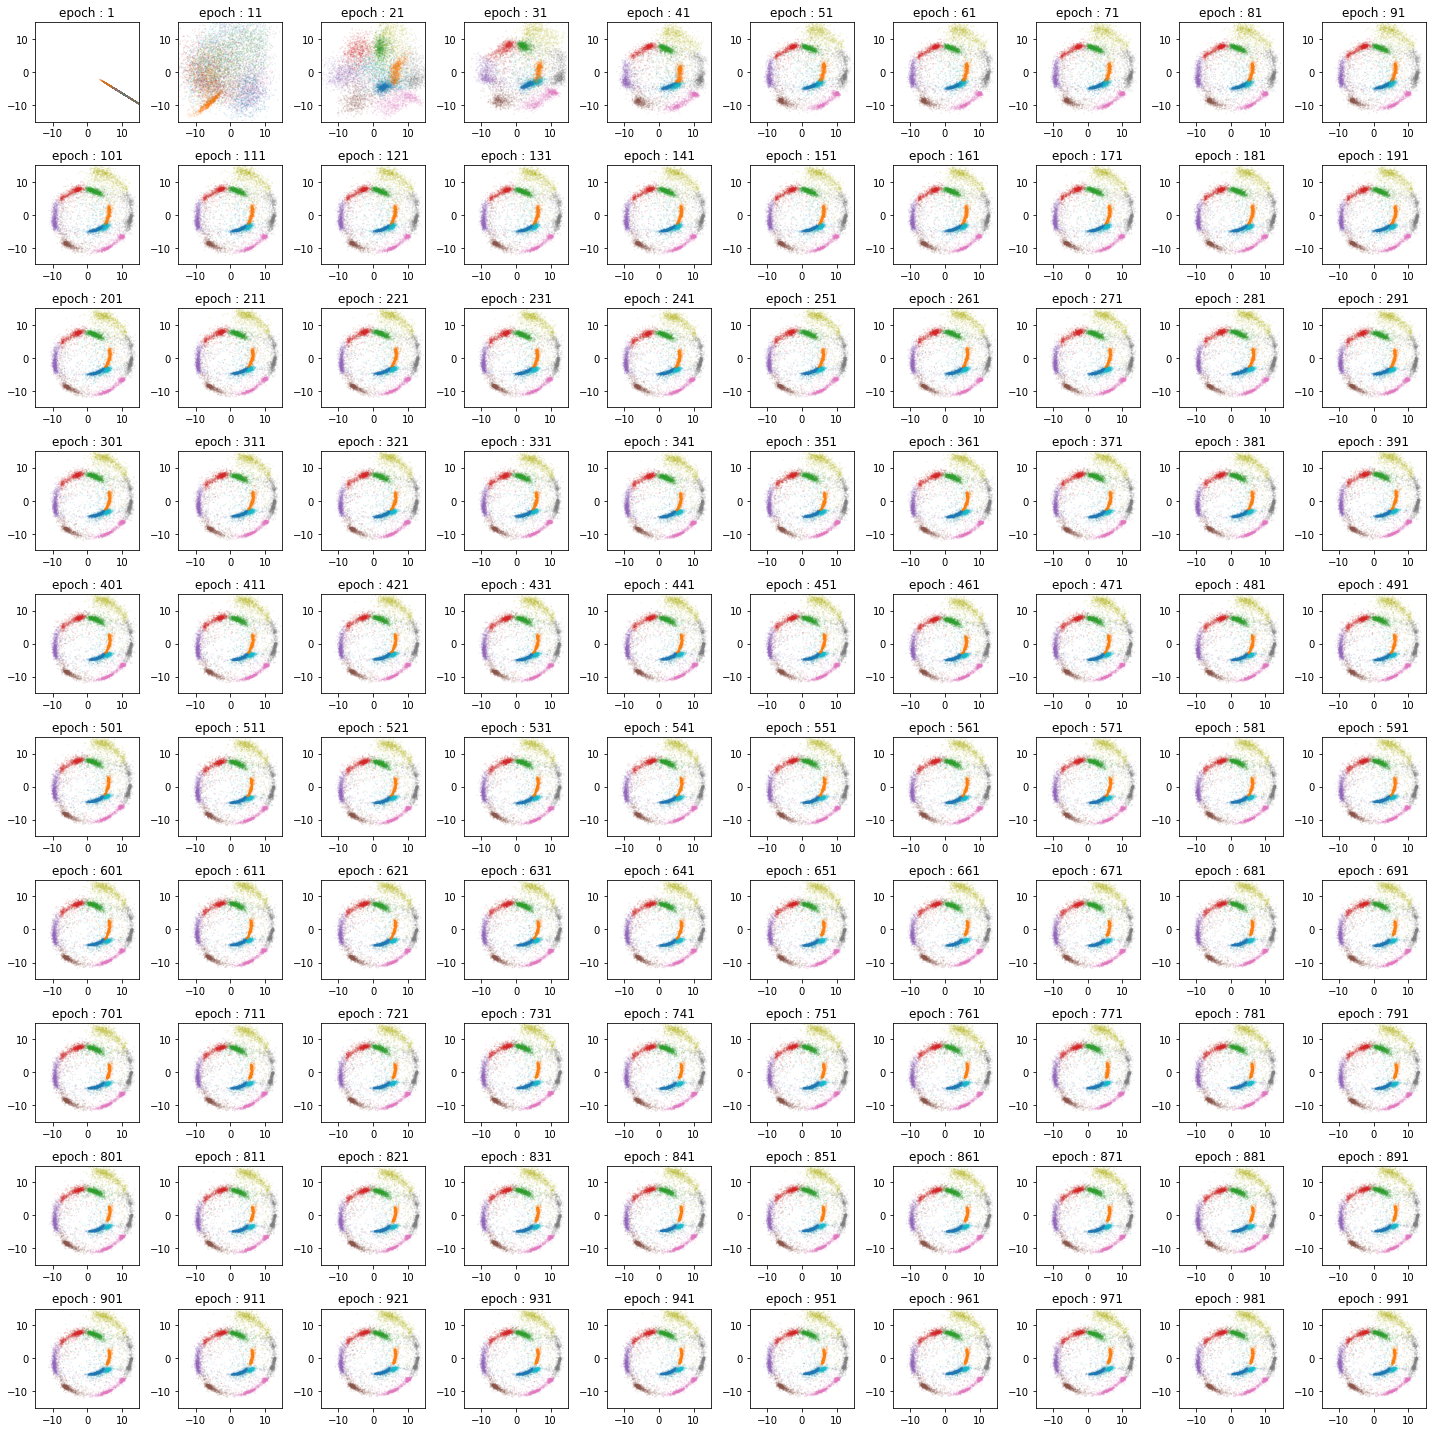

In [107]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i * 10][:,0], latent_history[i * 10][:,1], c = y_test, cmap = plt.cm.tab10, alpha = .7, s = .01)
    ax[i//10, i%10].set_title(f'epoch : {(i * 10) + 1}')
    ax[i//10, i%10].set_xlim(-15,15)
    ax[i//10, i%10].set_ylim(-15,15)
plt.tight_layout()

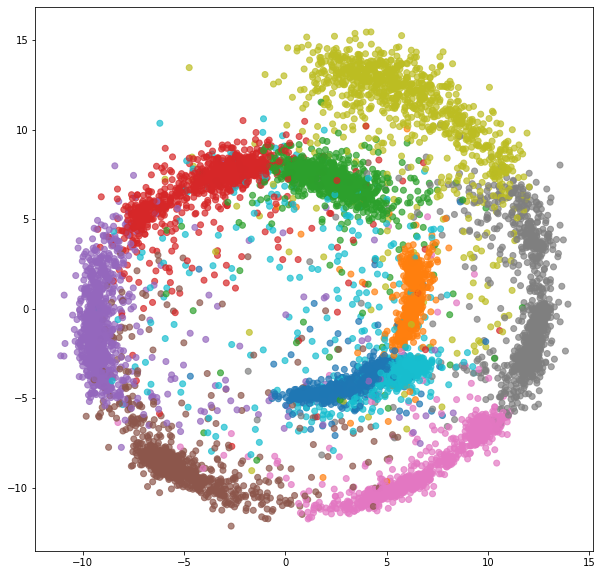

In [111]:
fig, ax = plt.subplots(figsize = (10, 10))
latent_z = lr_aae.encode(x_test)
ax.scatter(latent_z[:,0], latent_z[:,1], c = y_test, cmap = plt.cm.tab10, alpha = .7)

<a id='ssaae'><h3>semi-supervised autoencoder</h3></a>

In [8]:
class SSAAE(tf.keras.Model):
    def __init__(self, n_nodes, n_components, input_dim, n_categories, gaussian_noise:bool = True, stddev:float = .3, dropout:bool = False, dropout_rate:float = .2, batch_normalization:bool = False):
        '''
        ssaae 구성
        n_nodes : 모든 레이어(encoder, decoder, discriminator)들의 유닛 개수
        n_components : 잠재공간 z의 차원
        input_dim : X의 차원
        n_categores : y의 category 갯수
        gaussian_noise : input layer 직후에 gaussian noise layer 추가여부
        stddev : gaussian noise 추가시 noise의 표준편차
        dropout : input layer 직후에 dropout layer 추가여부
        dropout_rate : dropout layer 추가시 삭제할 비율
        batch_normalization : encoder와 decoder에 BN 추가여부
        
        layer의 갯수는 일단 논문과 같이 2개로 고정함.
        initializer도 stddev .01의 gaussian distribution으로 고정(논문따라서)
        '''
        super(SSAAE, self).__init__()
        np.random.seed(seed = 42)
        tf.random.set_seed(seed = 42)
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        self.n_categories = n_categories
        self.gaussian_noise = gaussian_noise
        self.dropout = dropout
        self.stddev = stddev
        self.dropout_rate = dropout_rate
        self.batch_normalization = batch_normalization
        self.acc = tf.keras.metrics.Accuracy() #추후비교용
        
        #encoder(q) == generator
        encoder_input = tf.keras.layers.Input(shape = [self.input_dim], name = 'encoder_input')
        if self.gaussian_noise:
            encoder_hidden = tf.keras.layers.GaussianNoise(stddev = self.stddev, name = 'gaussian_noise')(encoder_input)
        if self.dropout:
            encoder_hidden = tf.keras.layers.Dropout(rate = self.dropout_rate, name = 'dropout')(encoder_input)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        #encoder input 쪽이 부자연수럽긴한데 일단 구현하는게 목적이라 대충만듬.
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 1), name = 'encoder_hidden_1')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 2), name = 'encoder_hidden_2')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        latent_z = tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 3), name = 'latent_z')(encoder_hidden)
        latent_y = tf.keras.layers.Dense(self.n_categories, activation = 'softmax', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 4), name = 'latent_y')(encoder_hidden)
        self.encoder = tf.keras.Model(inputs = [encoder_input], outputs = [latent_z, latent_y])
        '''
        X를 받아서 latent_z(gaussian distribution)과 latent_y(Categorical distribution)을 출력하는 encoder
        '''
        
        #decoder(p)
        decoder_input = tf.keras.layers.Input(shape = [self.n_components + self.n_categories], name = 'decoder_input')
        if self.batch_normalization:
            decoder_input = tf.keras.layers.BatchNormalization()(decoder_input)
        decoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 5), name = 'decoder_hidden_1')(decoder_input)
        if self.batch_normalization:
            decoder_hidden = tf.keras.layers.BatchNormalization()(decoder_hidden)
        decoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 6), name = 'decoder_hidden_2')(decoder_hidden)
        if self.batch_normalization:
            decoder_hidden = tf.keras.layers.BatchNormalization()(decoder_hidden)
        reconstruction = tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 7), name = 'reconstruction')(decoder_hidden)
        self.decoder = tf.keras.Model(inputs = [decoder_input], outputs = [reconstruction])
        '''
        latent_z와 latent_y를 받아 다시 X를 출력하는 decoder
        '''
        
        
        #discriminator_z
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components], name = 'discriminator_z_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 8), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 9), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 10), name = 'discriminator_z_output')
            ])
        '''
        latent_z와 gaussian distribution을 받아 어떤것이 진짜인지 구별하는 discriminator_z
        '''
        
        #discriminator_y
        self.discriminator_y = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_categories], name = 'discriminator_y_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 11), name = 'discriminator_y_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 12), name = 'discriminator_y_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 13), name = 'discriminator_y_output')
            ])
        '''
        latent_y와 categorical distribution(y)를 받아 어떤것이 진짜인지 구별해주는 discriminator_y
        '''
    
    #define forward propagation functions
    
    #reconstruction phase
    @tf.function
    def encode(self, x, training = False):
        '''
        X를받아 latent_z와 latent_y를 반환함.
        training은 gaussian noise layer 활성화를 위함
        '''
        latent_z, latent_y = self.encoder(x, training = training)
        return latent_z, latent_y
    
    #regularizatio phase
    @tf.function
    def decode(self, z, y):
        '''
        latent_z와 latent_y를 받아 reconstruction(X)를 반환함
        '''
        inputs = tf.concat([z, y], axis = 1)
        reconstruction = self.decoder(inputs)
        return reconstruction
    @tf.function
    def discriminate_z(self, z):
        '''
        gaussian distribution이나 latent_z를 받아 어떤것이 진짜(gaussian distribution)인지 logit을 반환
        '''
        output = self.discriminator_z(z)
        return output
    
    #semi-supervised classification phase
    @tf.function
    def discriminate_y(self, y):
        '''
        categorical_distribution(y)나 latent_y를 받아 어떤것이 진짜(categorical_dsitribution(y))인지 logit을 반환
        '''
        output = self.discriminator_y(y)
        return output

#define loss computing functions
def compute_reconstruction_loss(x, reconstruction):
    '''
    X와 재구성된 X(reconstruction)의 차이 계산
    half euclidean(논문따라)
    '''
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    '''
    discriminator의 fake distribution의 discriinator logit과 label(0)의 loss + true distribution의 discriminator과 label(1)의 loss 반환
    '''
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    '''
    fake distribution을 true distribution과 유사하게만들기 위해 fake distribution과 label(1)의 loss 반환
    '''
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

def compute_classification_loss(x, y):
    '''
    minibatch 중 label된 y와 q(y|x)로 예측한 y_hat loss 반환
    '''
    classification_loss = tf.reduce_mean(K.categorical_crossentropy(target = x, output = y))
    return classification_loss

    
#define train function
@tf.function
def train_step(model, x, x_labeled, x_unlabeled, y, y_labeled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer):
    '''
    train 내에서 minibatch의 label유무로 데이터분할하니 오류가생겨서 밖으로 뺌
    true_output_y도 내부에서 Cat(y)를 생성하면 에러가생겨서 밖으로 빼버림
    
    model : adversarial encoder
    x : minibatch x
    x_labeled : minibatch 중 label이 있는 x
    x_unlabeled : minibatch 중 label이 있는 x
    y : minibatch y
    y_labeled : minibatch 중 label이 있는 y
    optimizers : { r : reconstruction, d : discriminator, g : generator , ss :semi_supervised classification }
    '''
    
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x_unlabeled, True)
        reconstruction = model.decode(latent_z, latent_y)
        reconstruction_loss = compute_reconstruction_loss(x_unlabeled, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #regularization
    model.discriminator_z.trainable = True
    model.discriminator_y.trainable = True
    model.encoder.trainable = False
    #discriminator만 학습하기위해 encoder(generator 동결)
    true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42)
    latent_z, latent_y = model.encode(x, True)
    #z
    with tf.GradientTape() as tape:
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))
    #y
    with tf.GradientTape() as tape:
        fake_y_logit = model.discriminate_y(latent_y)
        true_y_logit = model.discriminate_y(true_output_y)
        discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    d_gradients = tape.gradient(discriminator_y_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator
    model.discriminator_z.trainable = False
    model.discriminator_y.trainable = False
    model.encoder.trainable = True
    #generator(encoder)만 학습하기 위해 discriminator 동결
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x, True)
        fake_z_output = model.discriminate_z(latent_z)
        generator_z_loss = compute_generator_loss(fake_z_output)
        fake_y_output = model.discriminate_y(latent_y)
        generator_y_loss = compute_generator_loss(fake_y_output)
    g_gradients = tape.gradient([generator_z_loss, generator_y_loss], model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    #ss_classification
    with tf.GradientTape() as tape:
        _, latent_y = model.encode(x_labeled, True)
        classification_loss = compute_classification_loss(y_labeled, latent_y)
    ss_gradients = tape.gradient(classification_loss, model.trainable_variables)
    ss_optimizer.apply_gradients(zip(ss_gradients, model.trainable_variables))
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss         

#define test function
@tf.function
def test_step(model, x, y, true_output_y):
    '''
    test set에 대해 앞에 말한것들을 돌려보고 결과값 반환
    training = False로 기본값 넣어둬서 gaussian noise layer가 deactive됨
    '''
    latent_z, latent_y = model.encode(x)
    reconstruction = model.decode(latent_z, latent_y)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    
    true_output_z = tf.random.normal(shape=(latent_z.shape), seed = 42)
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    fake_y_logit = model.discriminate_y(latent_y)
    true_y_logit = model.discriminate_y(true_output_y)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    generator_y_loss = compute_generator_loss(fake_y_logit)
    
    classification_loss = compute_classification_loss(y, latent_y)
    accuracy = model.acc(tf.argmax(y, axis = 1), tf.argmax(latent_y, axis = 1))
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss, accuracy

<h5>학습데이터 불러오기 및 모델, optimizer 정의</h5>

mnist에 대해 미리 돌려보고 작동 잘 하는지 확인한다음에 project에 적용해볼것임

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
color = y_test

y_train = y_train.astype('float32')
#원래 하려했던 책 분류의 경우처럼 97%를 na로 날림
for i in range(600):
    y_train[i * 100:(i*100)+97] = np.nan
    
#cat(y)
idx, counts = np.unique(y_train[~np.isnan(y_train)], return_counts = True)
y_prob = counts / counts.sum()
y_train = tf.convert_to_tensor(y_train, dtype = 'float32')

x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_train = tf.convert_to_tensor(x_train, dtype='float32')
x_test = tf.convert_to_tensor(x_test, dtype = 'float32')
y_test = tf.convert_to_tensor(pd.get_dummies(y_test), dtype = 'float32')

#1000 units, 10-D gaussian, inputshape, 10 categories, ...
ssaae = SSAAE(1000, 10, x_train.shape[1], 10, gaussian_noise= True)

#appendix 그대로 넣었더니 발산해서 1/5로 줄였더니발산해서 1/10으로 줄임
r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
ss_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_y_history = []
latent_z_history = []
rh = []
dzh = []
dyh = []
gzh = []
gyh = []
ssch = []

y_categories = 10
    

    
for j in tqdm(range(5000)):
    #epoch 500
    if j == 49:
        r_optimizer.lr  = r_optimizer.lr / 10.
        ss_optimizer.lr = ss_optimizer.lr / 10.
        d_optimizer.lr = d_optimizer.lr / 10.
        g_optimizer.lr = g_optimizer.lr / 10.
    if j == 499:
        r_optimizer.lr  = r_optimizer.lr / 10.
        ss_optimizer.lr = ss_optimizer.lr / 10.
        d_optimizer.lr = d_optimizer.lr / 10.
        g_optimizer.lr = g_optimizer.lr / 10.
    
    reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss = [],[],[],[],[],[]
    for i in range(600):
        #preprocessing
        #mini batch 구성하고 label여부로 minibatch 내에서 구분
        x_batch_train = x_train[i * 100:(i+1)*100]
        y_batch_train = y_train[i * 100:(i+1)*100]
        mask = tf.math.is_nan(y_batch_train)
        x_unlabeled = tf.boolean_mask(x_batch_train, mask)
        x_labeled = tf.boolean_mask(x_batch_train, ~mask)
        y_labeled = tf.boolean_mask(y_batch_train, ~mask)
        y_labeled = tf.keras.utils.to_categorical(y_labeled, num_classes = y_categories)
        true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = 10)
        
        #train
        r, dz, dy, gz, gy, s = train_step(ssaae, x_batch_train, x_labeled, x_unlabeled, y_batch_train, y_labeled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer)
        reconstruction_loss.append(r)
        discriminator_z_loss.append(dz)
        discriminator_y_loss.append(dy)
        generator_z_loss.append(gz)
        generator_y_loss.append(gy)
        classification_loss.append(s)
    
    #test
    true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = y_categories)
    test_reconstruction, test_discriminator_z, test_discriminator_y, test_generator_z, test_generator_y, test_classification, test_accuracy = test_step(ssaae, x_test, y_test, true_output_y)
    reconstruction_loss = np.mean(reconstruction_loss)
    discriminator_z_loss = np.mean(discriminator_z_loss)
    discriminator_y_loss = np.mean(discriminator_y_loss)
    generator_z_loss = np.mean(generator_z_loss)
    generator_y_loss = np.mean(generator_y_loss)
    classification_loss = np.mean(classification_loss)
    
    #test결과 plot으로 넣어주기위해 가져옴
    rh.append(test_reconstruction)
    dzh.append(test_discriminator_z)
    dyh.append(test_discriminator_y)
    gzh.append(test_generator_z)
    gyh.append(test_generator_y)
    ssch.append(test_accuracy)
    #잠재공간들도 시각화위해 저장
    z, y =ssaae.encode(x_test)
    latent_y_history.append(y)
    latent_z_history.append(z)
    
    print(f'epoch : {j + 1} train set : [ reconstruction_loss : {reconstruction_loss}, discriminator_z_loss : {discriminator_z_loss}, discriminator_y_loss : {discriminator_y_loss}, generator_z_loss : {generator_z_loss}, generator_y_loss : {generator_y_loss}, classification_loss : {classification_loss}]')
    print(f'epoch : {j + 1} test set : [ reconstruction_loss : {test_reconstruction}, discriminator_z_loss : {test_discriminator_z}, discriminator_y_loss : {test_discriminator_y}, generator_z_loss : {test_generator_z}, generator_y_loss : {test_generator_y}, classification_loss : {test_classification}, test_accuracy : {test_accuracy}]')

<h5>latent_z의 1,2차원의 변화를 시각화해봄</h5>

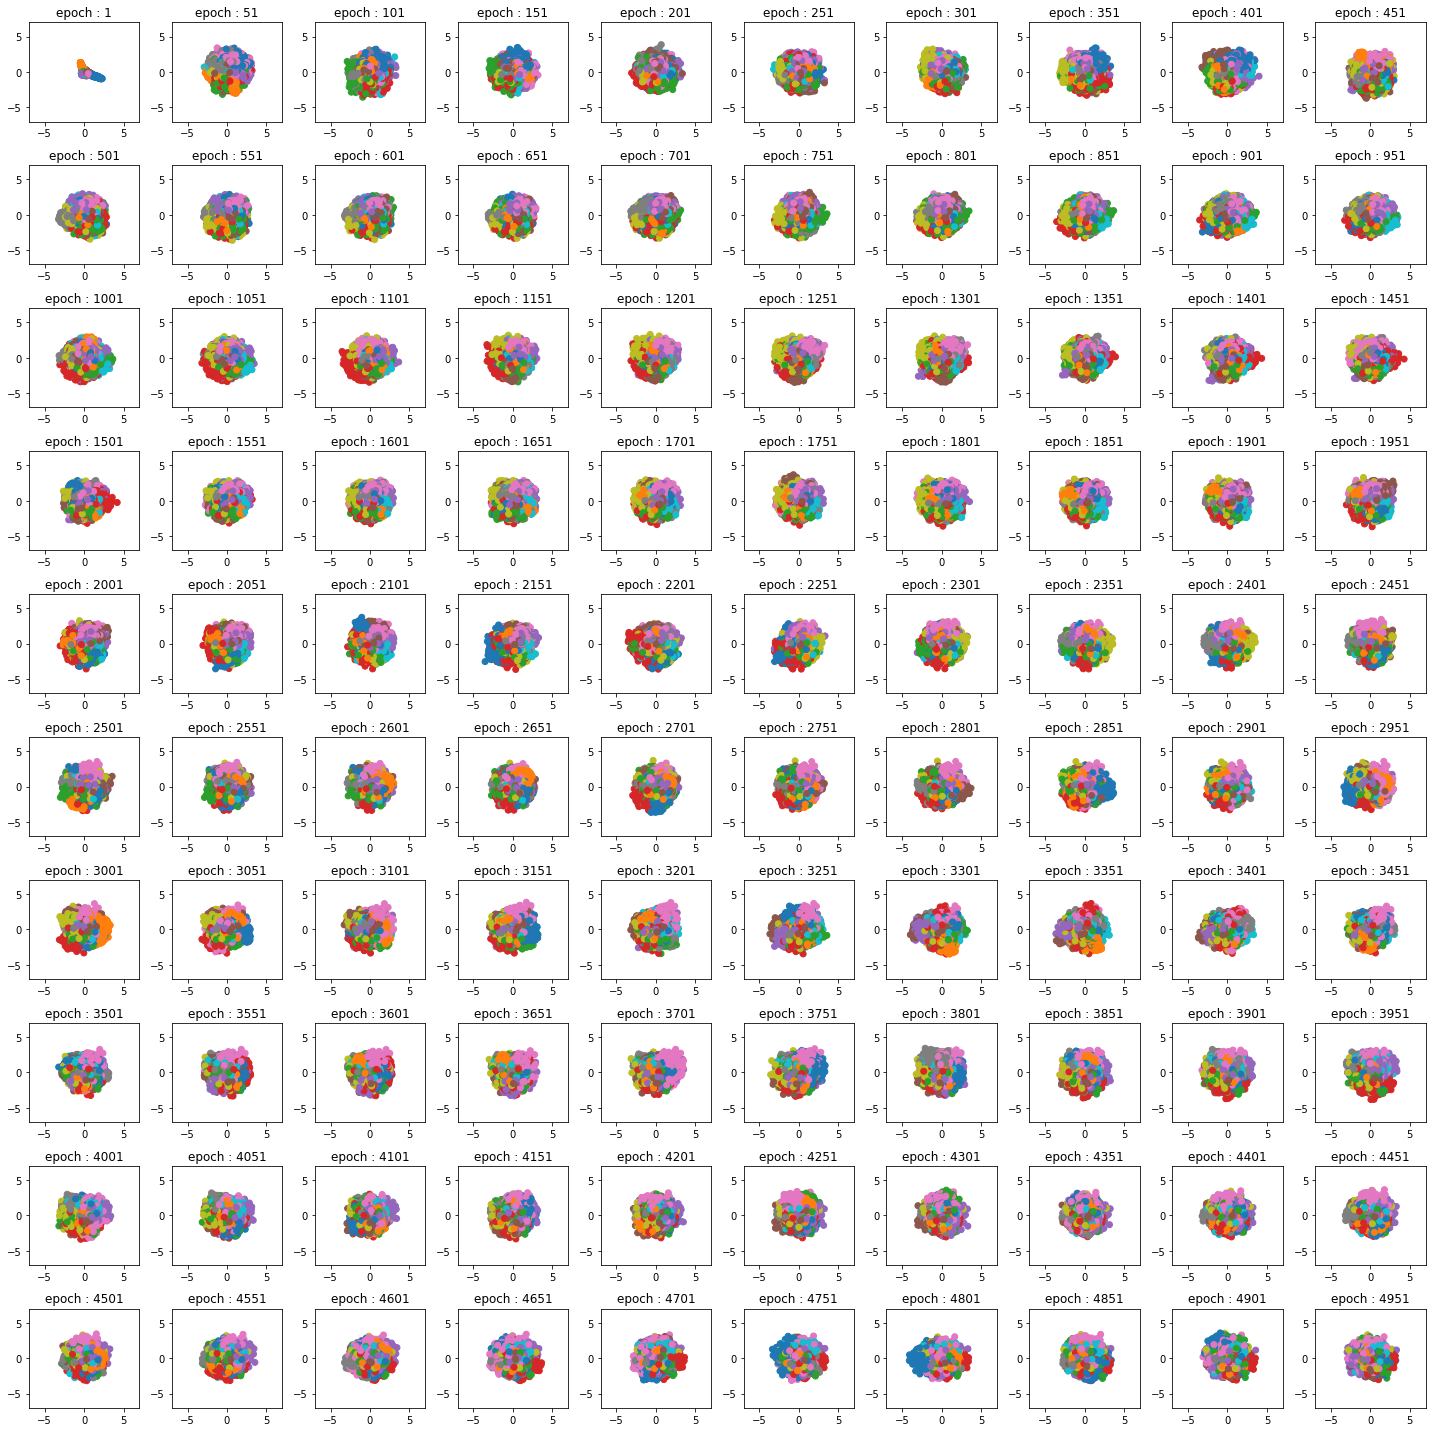

In [11]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_z_history[i*50][:,0], latent_z_history[i*50][:,1], c = color, cmap = plt.cm.tab10)
    ax[i//10, i%10].set_title(f'epoch : {(i * 50) + 1}')
    ax[i//10, i%10].set_xlim(-7,7)
    ax[i//10, i%10].set_ylim(-7,7)
plt.tight_layout()

<h5>결과 encoder의 latent_z의 10차원을 각각 찍어봄</h5>

모든 차원이 gaussian distribution을 잘따라고있는것이 보임.

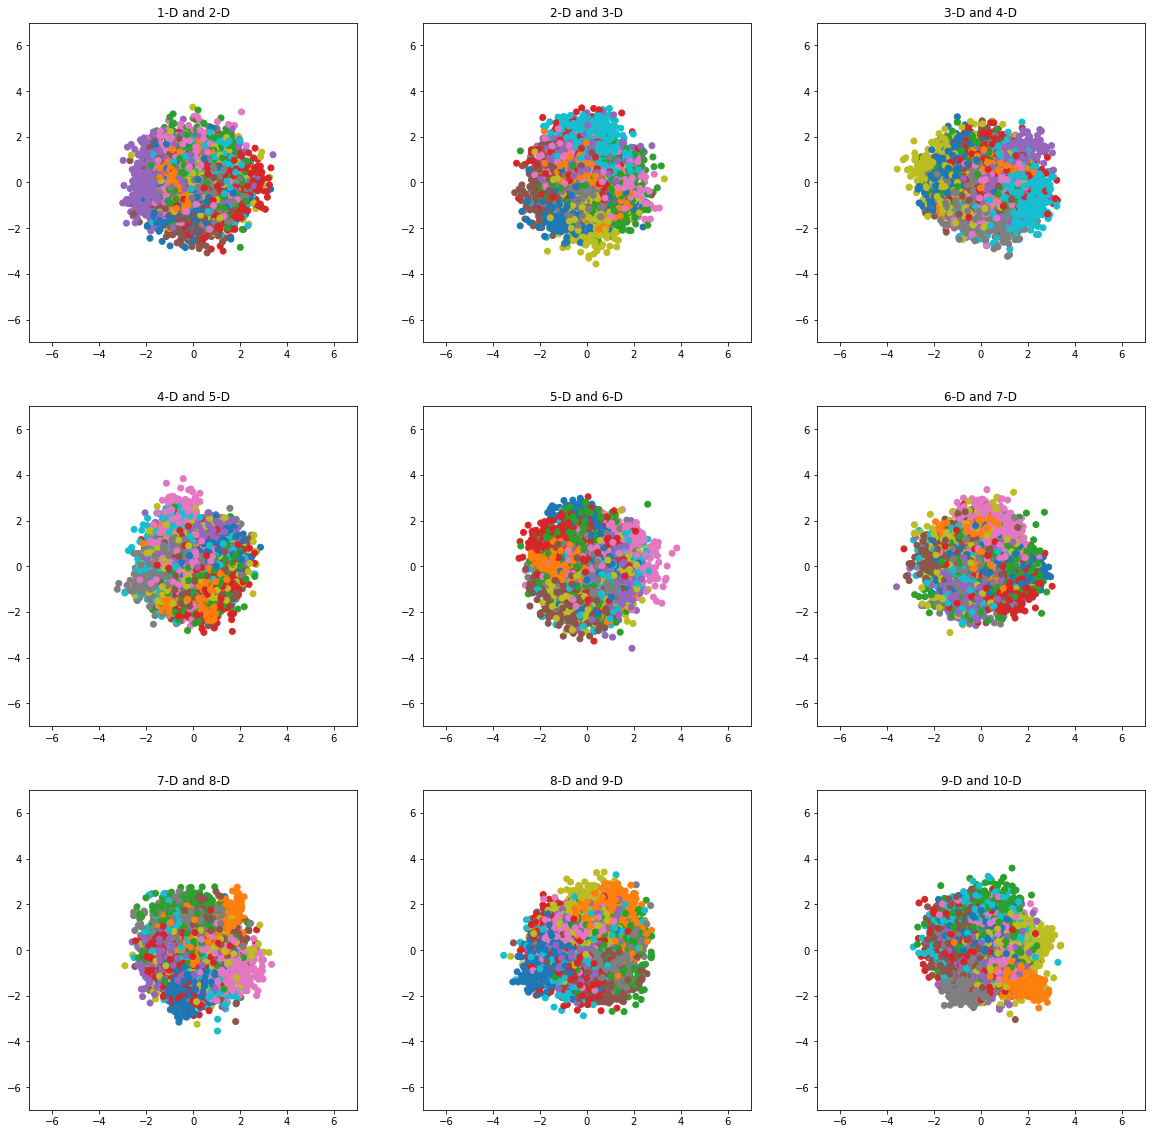

In [12]:
fig, ax = plt.subplots(3,3, figsize = (20, 20))
latent_z, _ = ssaae.encoder(x_test)
for i in range(9):
    ax[i//3, i%3].scatter(latent_z[:,i], latent_z[:,i+1], c = color, cmap = plt.cm.tab10)
    ax[i//3, i%3].set_title(f'{i+1}-D and {i+2}-D')
    ax[i//3, i%3].set_xlim(-7,7)
    ax[i//3, i%3].set_ylim(-7,7)

<h5>500 epochs동안 test set의 loss와 accuracy 시각화</h5>

Text(0.5, 1.0, 'semi-supervised classification accuracy')

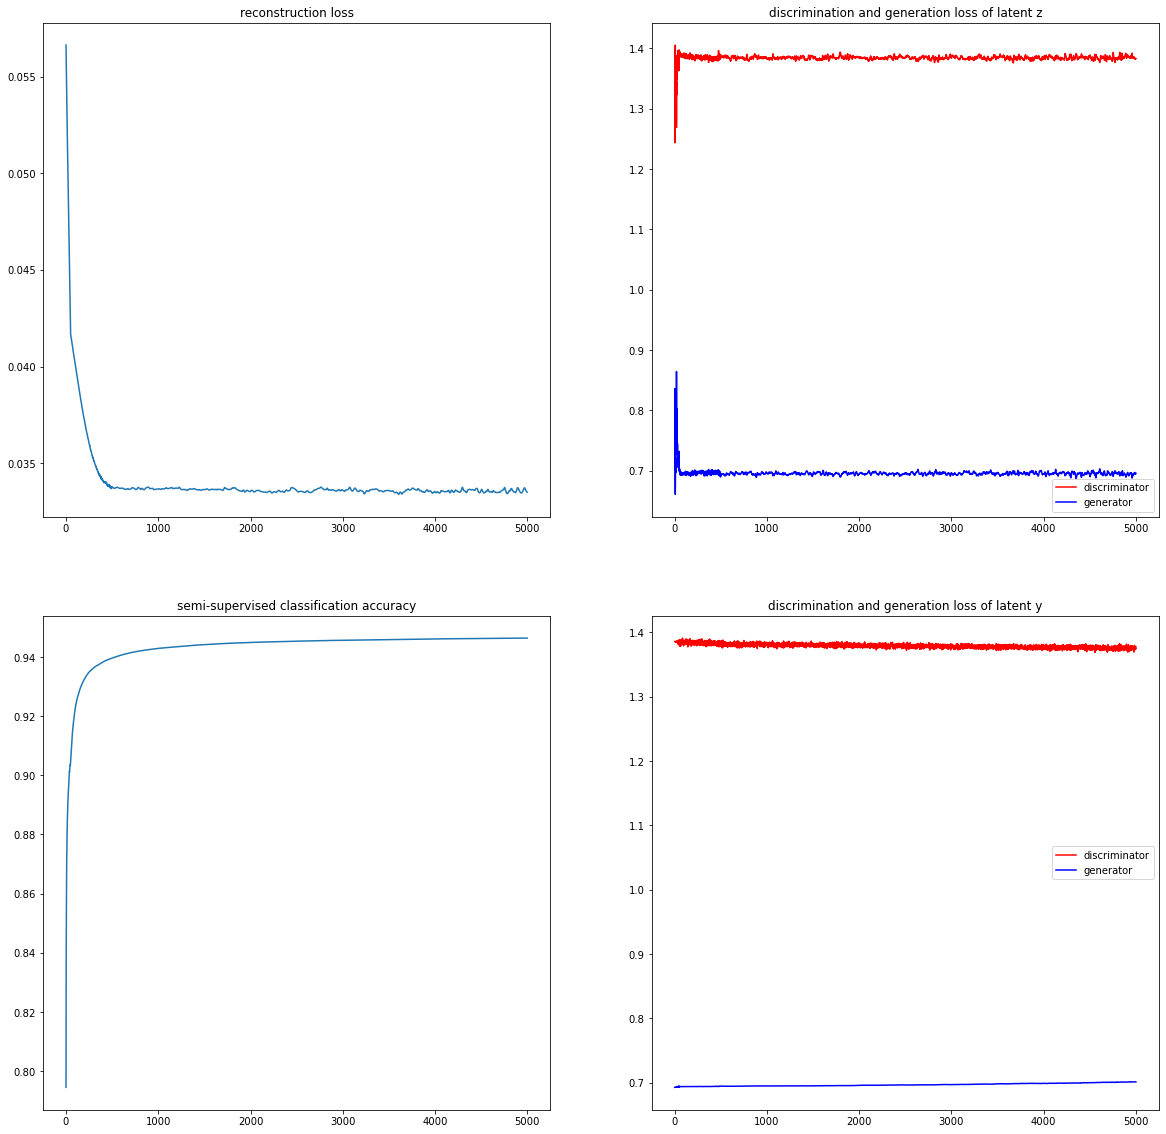

In [13]:
fig, ax = plt.subplots(2,2, figsize = (20,20))


ax[0,0].plot(rh)
ax[0,0].set_title('reconstruction loss')
ax[0,1].plot(dzh, color = 'red', label = 'discriminator')
ax[0,1].plot(gzh, color = 'blue', label = 'generator')
ax[0,1].legend()
ax[0,1].set_title('discrimination and generation loss of latent z')
ax[1,1].plot(dyh, color = 'red', label = 'discriminator')
ax[1,1].plot(gyh, color = 'blue', label = 'generator')
ax[1,1].legend()
ax[1,1].set_title('discrimination and generation loss of latent y')
ax[1,0].plot(ssch)
ax[1,0].set_title('semi-supervised classification accuracy')

https://arxiv.org/pdf/1511.05644.pdf


appendix A:

encoder ,decoder ,discriminator 모두 2 layer, 1000 units, relu  
cost function : half euclidean  
encoder last layer : softmax, linear  
latent_z : 10-D gaussian  
semi supervised classification cost function : CE  
momentum sgd : reconstruction, semi-supervised .9 / discriminator, generator .1  
lr : reconstruction .01  /  semi-supervised, discriminator, generator .1  
gaussian noise stddev .3 for train  
no dropout, l2reg, gaussian noise for other layers  
bn does not helps for MNIST